# 03. Computer Vision

In [37]:
# Import torch
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

print(torch.__version__)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
    
print(device)

2.3.0.post100
mps


## 1. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_dataset = datasets.MNIST(
    root='.',
    train = True,
    transform = ToTensor(),
    download = True,
    target_transform = None
)

test_dataset = datasets.MNIST(
    root='.',
    train = False,
    transform = ToTensor(),
    download = True,
    target_transform = None
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 18785058.44it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 855858.85it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 6152068.97it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 6213479.70it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## 2. Visualize a sample of the MNIST training dataset.

Image Shape -  torch.Size([1, 28, 28])


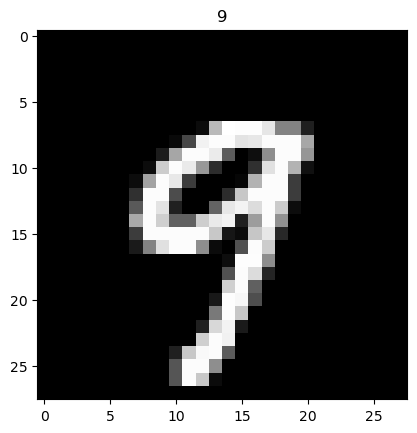

In [38]:
import matplotlib.pyplot as plt

random_index = torch.randint(0, 5000, (1,)).item()
image, label = train_dataset[random_index]

print('Image Shape - ', image.shape)
plt.title(label)
plt.imshow(image.squeeze(), cmap='gray')

## 3. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [71]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## 4. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [54]:
class ImageClassificationModel(nn.Module):
    
    def __init__(self, input_channels, hidden_channels, output_channels):
        
        super().__init__()
        
        self.layer_1 = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer_2 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.layer_3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_channels*7*7, output_channels)
        )
     
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
image_classification_model = ImageClassificationModel(1, 10, 10).to(device)
image_classification_model

ImageClassificationModel(
  (layer_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 5. Train the model for 5 epochs on CPU and GPU and see how long it takes on each.

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(image_classification_model.parameters(), lr=0.01)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# Training
epochs = 5

image_classification_model.train()
for i in torch.arange(epochs):
    train_loss = 0
    train_acc = 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        
        X = X.to(device)
        y = y.to(device)
        
        y_logits = image_classification_model(X)
        
        loss = loss_fn(y_logits, y)
        train_loss = train_loss + loss
        
        acc = accuracy_fn(y, torch.argmax(y_logits, dim=1))
        train_acc = train_acc + acc
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    
    print(f'Epoch - {i}, Train Loss - {train_loss}, Train Accuracy - {train_acc}')
        

Epoch - 0, Train Loss - 0.06807397305965424, Train Accuracy - 97.93
Epoch - 1, Train Loss - 0.06219526380300522, Train Accuracy - 98.10833333333333
Epoch - 2, Train Loss - 0.05857322737574577, Train Accuracy - 98.23833333333333
Epoch - 3, Train Loss - 0.05424712970852852, Train Accuracy - 98.38666666666667
Epoch - 4, Train Loss - 0.05194689705967903, Train Accuracy - 98.47166666666666


## 6. Make predictions using your trained model and visualize comparing the prediciton to the target label.

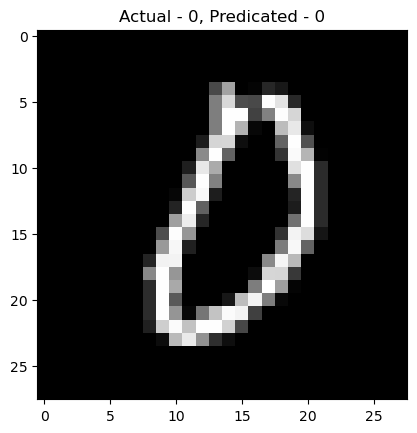

In [70]:
random_index = torch.randint(0, 5000, (1,)).item()
image, label = test_dataset[random_index]

image = image.to(device)
predicted_label = torch.argmax(image_classification_model(image.unsqueeze(dim=1)))
plt.title(f'Actual - {label}, Predicated - {predicted_label}')
plt.imshow(image.squeeze().cpu(), cmap='gray')

## 7. Plot a confusion matrix comparing your model's predictions to the truth labels.

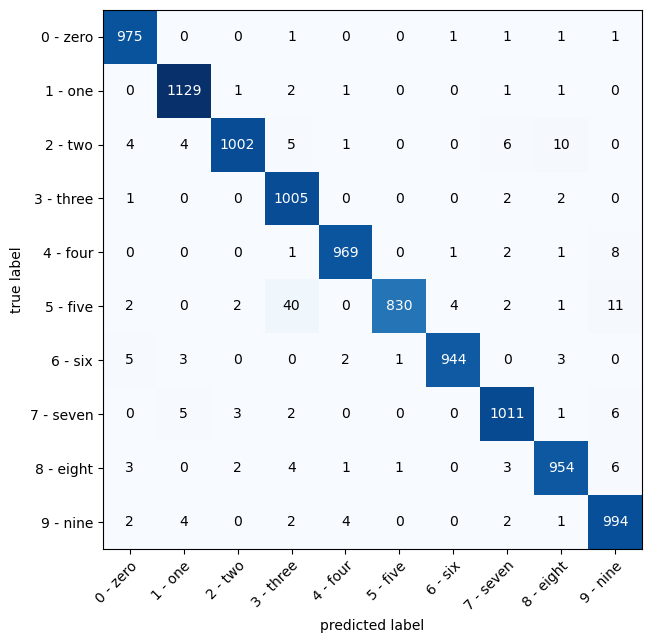

In [78]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_preds = []
image_classification_model.eval()
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
        X = X.to(device)
        y = y.to(device)

        y_logits = image_classification_model(X)

        y_pred = y_logits.argmax(dim=1)
        y_preds.append(y_pred.cpu())
    
y_pred_tensor = torch.cat(y_preds)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_dataset.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names,
    figsize=(10, 7)
);